# Importing libraries

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Loading data

In [ ]:
# Load data
!gdown 1o_qYYdr-2yd5HLIp8m9SvMAXwACx10Sw
# Read file in google drive
sales_data = pd.read_excel("/content/FORECASTING BUSINESS PERFORMANCE.xlsx", sheet_name=None)

Downloading...
From (original): https://drive.google.com/uc?id=1o_qYYdr-2yd5HLIp8m9SvMAXwACx10Sw
From (redirected): https://drive.google.com/uc?id=1o_qYYdr-2yd5HLIp8m9SvMAXwACx10Sw&confirm=t&uuid=5ee4031e-a1ce-4557-8406-c16f92be68dc
To: /content/FORECASTING BUSINESS PERFORMANCE.xlsx
100% 28.8M/28.8M [00:00<00:00, 115MB/s]


In [ ]:
# Access individual sheets using sheet names
sales = sales_data["SalesFact"]
location = sales_data["Geography"]
product = sales_data["Product"]

# Data exploration

In [ ]:
merged = sales.merge(right=location, left_on="Zip", right_on="Zip").merge(right=product, left_on="ProductID", right_on="ProductID")
print(merged)

        ProductID       Date    Zip  Units    Revenue          COGS  \
0            1228 2013-07-31  78773     12   19648.44  12309.747660   
1             781 2014-03-12  90501     16   20351.52  13497.128064   
2            2090 2013-11-29  44460     26  111367.62  91488.499830   
3            1116 2018-08-29  30122     12   36280.44  21967.806420   
4             993 2013-04-27  75789     14   55557.18  48645.866808   
...           ...        ...    ...    ...        ...           ...   
976238       2213 2013-08-12  15135      1    1070.37    749.794185   
976239       2213 2011-12-04  80120      1    1070.37    749.794185   
976240       2213 2011-05-29  30028      1    1070.37    749.794185   
976241       2213 2014-04-01  65279      1    1070.37    749.794185   
976242       2213 2012-12-22  25526      1    1070.37    749.794185   

                      City State   Region      District Category  \
0               Austin, TX    TX  Central  District #23    Urban   
1          

In [ ]:
# Select important columns
sales_fact = merged[["Product", "Category", "Segment", "Date", "Units", "Revenue", "COGS", "City", "State"]].copy()

# Extract city from the string
sales_fact["City"] = sales_fact["City"].apply(lambda x: x.split(", ")[0])

# Convert date to Year, Month, Day
sales_fact["Year"] = sales_fact["Date"].dt.year
sales_fact["Quarter"] = sales_fact["Date"].dt.quarter
sales_fact["Month"] = sales_fact["Date"].dt.month
sales_fact["Day"] = sales_fact["Date"].dt.strftime("%A")

print(sales_fact)

             Product Category       Segment       Date  Units    Revenue  \
0        Pirum UC-30    Urban   Convenience 2013-07-31     12   19648.44   
1       Natura RP-69    Rural  Productivity 2014-03-12     16   20351.52   
2       Currus UC-25    Urban   Convenience 2013-11-29     26  111367.62   
3        Pirum RS-04    Rural        Select 2018-08-29     12   36280.44   
4       Natura UC-56    Urban   Convenience 2013-04-27     14   55557.18   
...              ...      ...           ...        ...    ...        ...   
976238  Aliqui RP-10    Rural  Productivity 2013-08-12      1    1070.37   
976239  Aliqui RP-10    Rural  Productivity 2011-12-04      1    1070.37   
976240  Aliqui RP-10    Rural  Productivity 2011-05-29      1    1070.37   
976241  Aliqui RP-10    Rural  Productivity 2014-04-01      1    1070.37   
976242  Aliqui RP-10    Rural  Productivity 2012-12-22      1    1070.37   

                COGS            City State  Year  Quarter  Month        Day  
0       1

In [ ]:
print(sales_fact.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976243 entries, 0 to 976242
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Product   976243 non-null  object        
 1   Category  976243 non-null  object        
 2   Segment   976243 non-null  object        
 3   Date      976243 non-null  datetime64[ns]
 4   Units     976243 non-null  int64         
 5   Revenue   976202 non-null  float64       
 6   COGS      976243 non-null  float64       
 7   City      976243 non-null  object        
 8   State     976243 non-null  object        
 9   Year      976243 non-null  int32         
 10  Quarter   976243 non-null  int32         
 11  Month     976243 non-null  int32         
 12  Day       976243 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(3), int64(1), object(6)
memory usage: 85.7+ MB
None


In [ ]:
print(sales_fact.describe())

                                Date          Units        Revenue  \
count                         976243  976243.000000  976202.000000   
mean   2015-05-19 12:04:44.048950528       1.029979    5837.443431   
min              2010-07-04 00:00:00       1.000000     427.770000   
25%              2012-09-19 00:00:00       1.000000    2141.370000   
50%              2014-11-06 00:00:00       1.000000    4724.370000   
75%              2017-06-20 00:00:00       1.000000    8564.850000   
max              2022-07-01 00:00:00      44.000000  334548.900000   
std                              NaN       0.326669    4659.683857   

                COGS           Year        Quarter          Month  
count  976243.000000  976243.000000  976243.000000  976243.000000  
mean     4824.894373    2014.880272       2.480556       6.473714  
min         0.000000    2010.000000       1.000000       1.000000  
25%      1855.012131    2012.000000       2.000000       4.000000  
50%      3787.942158    2014.

## 🚀 Combine `Category` and `Segment` to identify the most valuable product groupings and optimize store strategy.

In [ ]:
sales_fact["Type of Product"] = sales_fact["Category"] + "-" + sales_fact["Segment"]
product_type = sales_fact.groupby(["Year", "Type of Product"])["Units"].sum().reset_index()
stacked = product_type.pivot_table(index="Year", columns="Type of Product", values="Units")
# Null values
stacked = stacked.drop([2010, 2011])
print(stacked)


Type of Product  Mix-All Season  Mix-Productivity  Rural-Productivity  \
Year                                                                    
2012                     2231.0              10.0             47616.0   
2013                     2788.0              76.0             43636.0   
2014                     3334.0              80.0             36284.0   
2015                     3534.0             154.0             31816.0   
2016                     4362.0             552.0             22174.0   
2017                     2586.0             286.0             15038.0   
2018                     2207.0             208.0             10682.0   
2019                     2618.0             192.0              9570.0   
2020                     2873.0             266.0              8814.0   
2021                     3280.0              20.0              7260.0   
2022                     1942.0               4.0              3640.0   

Type of Product  Rural-Select  Urban-Convenience  

## 📊 Total Units of Types of Products over Years

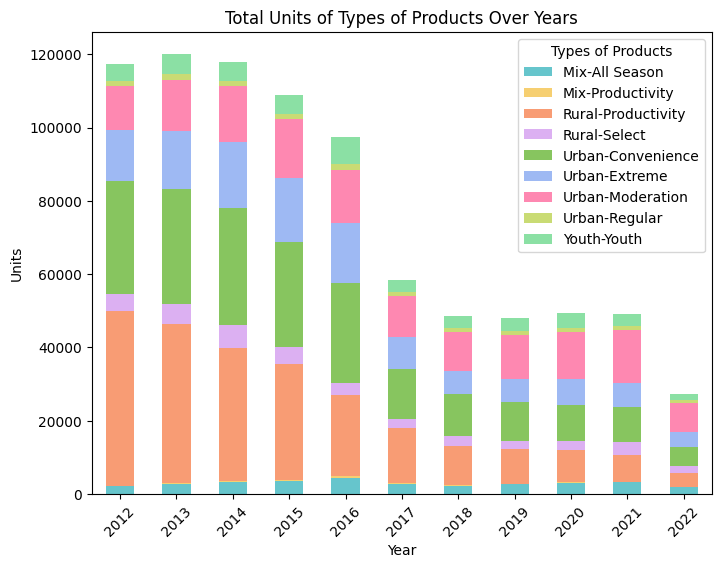

In [ ]:
# Function to convert rgb to hex
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))

# Convert plotly colors to hex
hex_colors = [rgb_to_hex(color[4:-1].split(',')) for color in px.colors.qualitative.Pastel]
# Plot
ax = stacked.plot(kind="bar", stacked=True, color=hex_colors, figsize=(8, 6))
plt.ylabel("Units")
plt.title("Total Units of Types of Products Over Years")
plt.legend(title="Types of Products")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# Save the figure
plt.savefig(f"Total Units of Types of Products Over Years", bbox_inches="tight", dpi=300)
plt.show()

## 📈Trend by Time Series

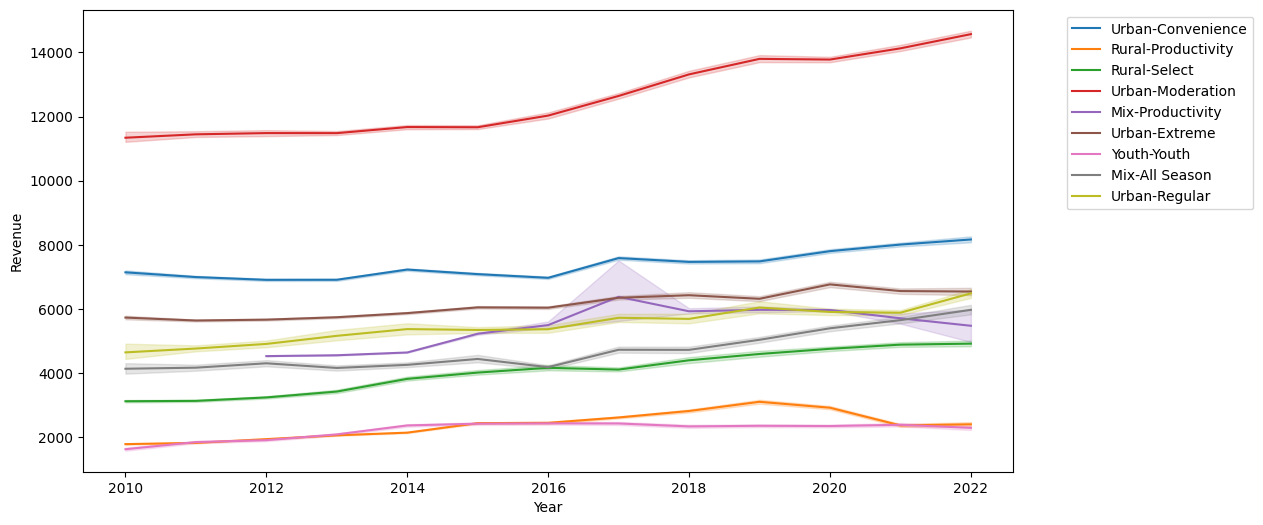

AttributeError: 'NoneType' object has no attribute 'legendHandles'

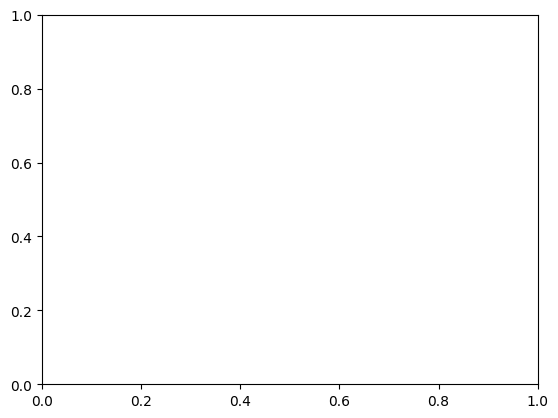

In [ ]:
time_feature = ["Year", "Quarter", "Month", "Day"]

for i in time_feature:
  plt.figure(figsize=(12, 6))
  sns.lineplot(data=sales_fact, x=sales_fact[i], y="Revenue", hue="Type of Product")
  plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

  # Save the figure
  # plt.savefig(f"{i}_Revenue_Trend.png", bbox_inches="tight", dpi=300)

  # Show the plot (optional)
  plt.show()

### Analysis
* There are no extreme daily fluctuations, but Friday shows a slight peak in revenue, potentially due to weekend shopping habits.
* End-of-year (December) sees the highest revenue for multiple categories.
* Early months (January-February) also see an increase, possibly due to post-holiday and New Year shopping.

### Recommendations
* Maximize sales in peak months (December, January) by launching promotions, discounts, and marketing campaigns.


## Statistics and Relationsip

Analyze the relationship between the price of segment and revenue generated by them.

In [ ]:
fig = px.scatter(sales_fact, x="Units", y="Revenue", color="Type of Product",
                 hover_data=["Date"], trendline="ols")
fig.show()

### Analysis
* The "Urban-Moderation" (Purple) category stands out with the highest revenue generating product. It suggests that either the price per unit is higher, or the demand is stronger for these items.
* Urban-Convenience" (Blue) and "Mix-Productivity" (Cyan) have moderately steep trendlines, meaning they have a balanced mix of sales volume and pricing.
* "Rural-Productivity" (Red) and "Rural-Select" (Brown) show flatter trendlines, indicating lower revenue generation per unit sold. These categories might have lower price points or weaker demand.
* Some data points at 30+ units sold show relatively low revenue, indicating possible discounts, bulk purchases, or lower-priced products.

### Recommendations
* Pricing Strategy: "Urban-Moderation" has strong revenue growth per unit. Consider expanding this product line or increasing marketing efforts.
* Sales Focus: If maximizing revenue, focus on high-revenue categories like Urban-Moderation and Urban-Convenience.
* Bulk Sales Strategy: Some product types (like Rural-Productivity) may need higher volume sales or bundle discounts to improve revenue.

## Ranking Analysis

In [ ]:
revenue_by_date = sales_fact.groupby("Date")[["Revenue"]].agg("sum")
px.line(revenue_by_date, y="Revenue")

## Top 5 cities attract the most revenues in each year

In [ ]:
sales_fact["Year"] = sales_fact["Date"].dt.year
# Set "Year" and "City" back to the headers
year_revenue = sales_fact.groupby(["Year", "City"])["Revenue"].agg("sum").reset_index()
# Top 5 cities attract the most in each year
top_cities_each_year = year_revenue.groupby("Year").apply(lambda x: x.nlargest(5, "Revenue"), include_groups=False).reset_index()
top_cities_each_year.head(15)

,Year,level_1,City,Revenue
0,2010,2999,Houston,1014809.67
1,2010,5736,San Diego,955550.61
2,2010,3517,Las Vegas,906559.92
3,2010,2269,Fort Lauderdale,800517.69
4,2010,1660,Denver,739860.03
5,2011,11324,Houston,2449849.50
6,2011,15075,San Diego,2133464.13
7,2011,12008,Las Vegas,2082063.69
8,2011,11519,Jacksonville,1978578.00
9,2011,9485,Denver,1932914.97


## Count of frequencies in top 5

In [ ]:
top_city_counts = top_cities_each_year["City"].value_counts()
print(top_city_counts)

City
Houston            13
Las Vegas          13
Miami              11
San Diego           9
Jacksonville        8
San Antonio         8
Denver              2
Fort Lauderdale     1
Name: count, dtype: int64


In [ ]:
top_cities_each_year["City"].unique()

array(['Houston', 'San Diego', 'Las Vegas', 'Fort Lauderdale', 'Denver',
       'Jacksonville', 'Miami', 'San Antonio'], dtype=object)

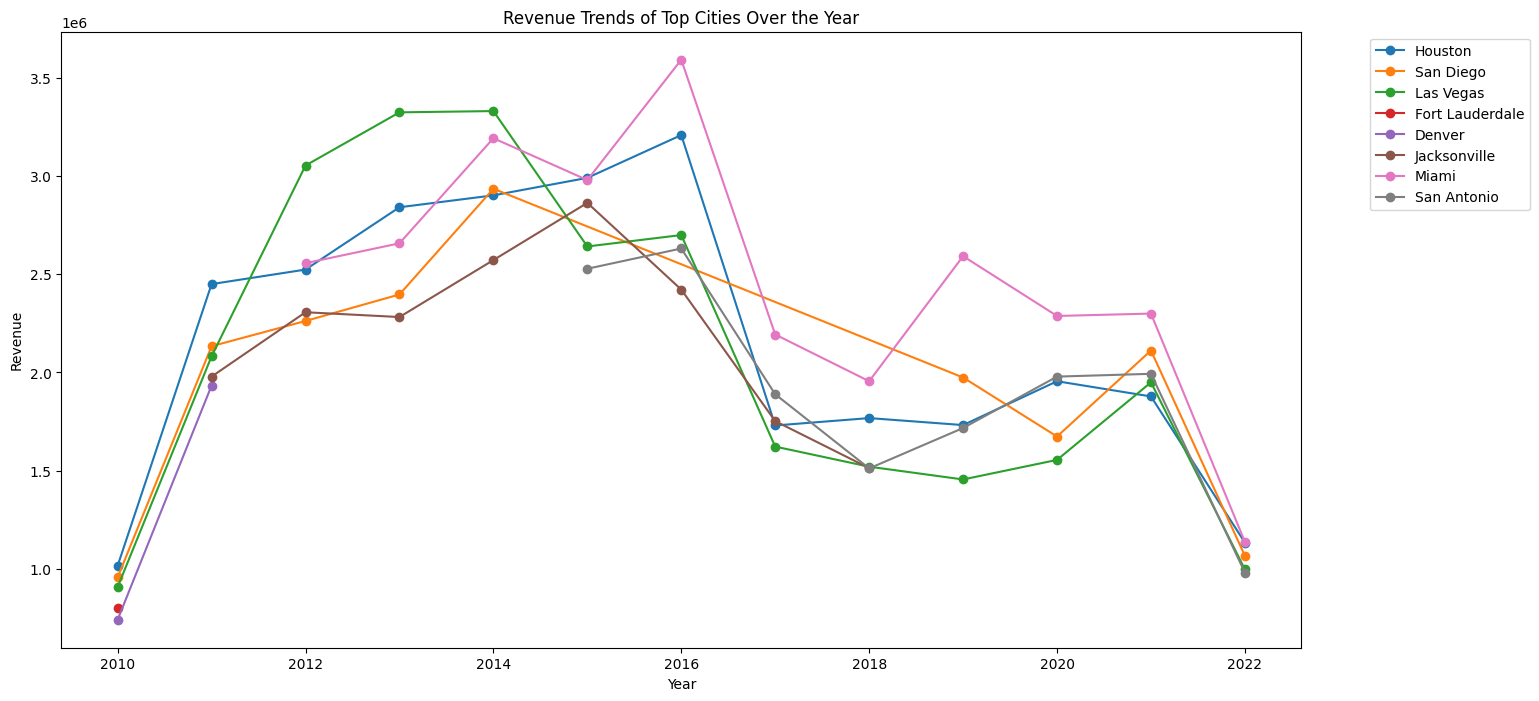

In [ ]:
plt.figure(figsize=(16,8))
# Generate a color palette with unique colors
colors = sns.color_palette("tab10", n_colors=len(top_cities_each_year["City"].unique()))

for i, city in enumerate(top_cities_each_year["City"].unique()):
  data = top_cities_each_year[top_cities_each_year["City"] == city]
  plt.plot(data["Year"], data["Revenue"], marker="o", label=city, color=colors[i])

plt.title("Revenue Trends of Top Cities Over the Year")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
# Save the figure
# plt.savefig(f"{i}_Revenue_Trend.png", bbox_inches="tight", dpi=300)

## Identify which segment and category is trending?

In [ ]:
df = sales_fact.groupby(["Year", "Type of Product"])["Product"].agg("count").reset_index()
df_sorted = df.groupby("Year").apply(lambda x: x.nlargest(5, "Product"), include_groups=False)
df_sorted = df_sorted.reset_index()
df_sorted.sort_values(by = ["Year", "Product"], ascending=False).head(20)

,Year,level_1,Type of Product,Product
60,2022,112,Urban-Moderation,7749
61,2022,110,Urban-Convenience,5070
62,2022,111,Urban-Extreme,3979
63,2022,108,Rural-Productivity,3490
64,2022,109,Rural-Select,2007
55,2021,103,Urban-Moderation,14066
56,2021,101,Urban-Convenience,9384
57,2021,99,Rural-Productivity,6942
58,2021,102,Urban-Extreme,6571
59,2021,100,Rural-Select,3437


Dòng `Urban Moderation`, `Urban Convenience`, `Urban Extreme`, `Rural Productivity`, `Rural Salect`, `Youth Youth` đang bán chạy trên thị trường trong những năm gần đây.